In [63]:
# Colab specific setup
try:
  from google.colab import drive
  
except Exception:
  # Local setup
  rootpath = "."

else:
  drive.mount('/content/drive')
  rootpath = '/content/drive/My Drive/6.869/pytorch-vqa-abs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import torch
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


In [65]:
!nvidia-smi

Fri Apr 22 20:38:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    41W / 250W |   1169MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [66]:
!pwd
import os 
os.chdir(rootpath)
!pwd

/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs


#### Process the images 
Use Restnet18 to compute the high level representation of the input image. The last layer of Resnet18 before the final pooling layer is used.

In [33]:
!python3 preprocess-images.py

not valid id 000000011220 (1).png
not valid id 000000015046 (1).png
not valid id 000000001033 (1).png
found 8611 images in ../image_dataset_abs/train2015
found 2000 images in ../image_dataset_abs/val2015
100% 166/166 [17:33<00:00,  6.35s/it]


#### Process the questions and answers.  

In [8]:
!python3 preprocess-vocab.py


### Train the model

In [94]:
!python3 train.py

will save to logs/2022-04-22_04:18:44.pth
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:127: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:84: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)
train E000: 100% 807/807 [00:34<00:00, 23.64it/s, acc=0.2914, loss=3.0563]
val E000: 100% 188/188 [00:08<00:00, 22.77it/s, acc=0.3716, loss=2.8428]
train E001: 100% 807/807 [00:35<00:00, 22.91it/s, acc=0.3544, loss=2.9900]
val E001: 100% 188/188 [00:07<00:00, 25.78it/s, acc=0.3949, loss=2.7014]
train E002: 100% 807/807 [00:34<00:00, 23.65it/s, acc=0.4332, loss=2.9351]
val E002: 100% 188/188 [00:07<00:00, 26.39it/s, acc=0.3988, loss=2.6449]
train E003: 100% 807/807 [00:32<00:00,

#### plot training process

In [95]:
!python view-log.py 'logs/2022-04-22_04:18:44.pth'

(-0.5, 639.5, 479.5, -0.5)

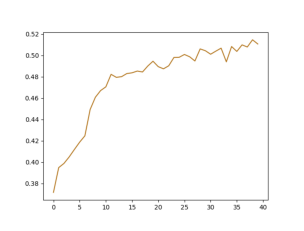

In [159]:
import matplotlib.pyplot as plt
import cv2
acc_plot = cv2.imread('val_acc.png')
plt.imshow(acc_plot)
plt.axis('off')

## Result & Visualization

### Retrieve the model 

In [114]:
import torch
import model

log = torch.load('logs/2022-04-22_02:43:55.pth') #strong base
tokens = len(log['vocab']['question']) + 1

net = torch.nn.DataParallel(model.Net(tokens)).to(device) # Net: strong base / Net0: shallow base
net.load_state_dict(log['weights'])

/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:127: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/content/drive/.shortcut-targets-by-id/1Ar7h59qYql2V1BVT_KCUpOwxAJ37yRsc/6.869/pytorch-vqa-abs/model.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)


<All keys matched successfully>

#### Image encoding

In [68]:
import data
import config
val_dataset = data.CocoImages(config.val_path, transform=None) 

found 2000 images in ../image_dataset_abs/val2015


#### Question and answer encoding 

In [70]:
import utils
import json
import data
questions_path = utils.path_for(train=False, val=True, test=False, question=True)
answers_path = utils.path_for(train=False, val=True, test=False, answer=True)
with open(questions_path, 'r') as fd:
    questions_json = json.load(fd)
with open(answers_path, 'r') as fd:
    answers_json = json.load(fd)
with open(config.vocabulary_path, 'r') as fd:
    vocab_json = json.load(fd)

# vocab
token_to_index = vocab_json['question']
answer_to_index = vocab_json['answer']
index_to_token = dict([(ind, tok) for tok, ind in answer_to_index.items()])

def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    vec = torch.zeros(max_question_len).long()
    for i, token in enumerate(question):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, len(question)

def encode_answers(answers):
    """ Turn an answer into a vector """
    # answer vec will be a vector of answer counts to determine which answers will contribute to the loss.
    # this should be multiplied with 0.1 * negative log-likelihoods that a model produces and then summed up
    # to get the loss that is weighted by how many humans gave that answer
    answer_vec = torch.zeros(len(answer_to_index))
    for answer in answers:
        index = answer_to_index.get(answer)
        if index is not None:
            answer_vec[index] += 1
    return answer_vec

# q and a
questions = list(data.prepare_questions(questions_json))
answers = list(data.prepare_answers(answers_json))
max_question_len = max(map(len, questions))

questions_encoded = [encode_question(q) for q in questions]
answers_encoded = [encode_answers(a) for a in answers]


#### Find a match between image and question 

In [97]:
image_item = 3
question_item = 2

In [93]:
import matplotlib.pyplot as plt
from PIL import Image
import config
import os

image_item = 3
item_list = list(val_dataset.id_to_filename.keys())
item_id = item_list[image_item]
item_file = val_dataset.id_to_filename[item_id]
item_img = Image.open(os.path.join(config.val_path, item_file)).convert('RGB')

Three questions associated with 29680
 What is in the center of the picture? 

['sandbox', 'sandbox', 'bird', 'bird', 'sandbox', 'bird', 'sandbox', 'bird', 'bird', 'sandbox']


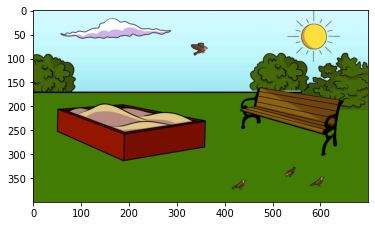

In [101]:
question_match = [q for q in questions_json['questions'] if q['image_id'] == item_id]
answer_match = [a for a in answers_json['annotations'] if a['image_id'] == item_id]
question_position = [i for i in range(len(questions_json['questions'])) if questions_json['questions'][i]['image_id'] == item_id]
print('Three questions associated with {}\n {} \n'.format(item_id, question_match[question_item]['question']))
plt.imshow(item_img)
print([answer_match[question_item]['answers'][i]['answer'] for i in range(10)])


#### Question & Answer encoding
question is encoded for each word across the question  
answer is encoded as one hot cumulative encoding

---



In [104]:
print('max question length is {}'.format(max_question_len))
print('answer list length is {}\n'.format(len(answer_to_index)))

print('Question')
print(questions[question_position[question_item]])
print(questions_encoded[question_position[question_item]])

print('Ten candidate answers')
print(answers[question_position[question_item]])
print(answers_encoded[question_position[question_item]])

max question length is 19
answer list length is 3000

Question
['what', 'is', 'in', 'the', 'center', 'of', 'the', 'picture']
(tensor([  3,   2,   8,   1, 477,  12,   1,  30,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0]), 8)
Ten candidate answers
['sandbox', 'sandbox', 'bird', 'bird', 'sandbox', 'bird', 'sandbox', 'bird', 'bird', 'sandbox']
tensor([0., 0., 0.,  ..., 0., 0., 0.])


#### Image feature

In [105]:
import h5py
features_file = h5py.File(config.preprocessed_path, 'r')
coco_ids = features_file['ids'][()]
coco_id_to_index = {id: i for i, id in enumerate(coco_ids)}
def load_image(image_id):
    """ Load an image """
    index = coco_id_to_index[image_id]
    dataset = features_file['features']
    img = dataset[index].astype('float32')
    return torch.from_numpy(img)

#### Model output

In [115]:
v = load_image(item_id)
q, q_len = questions_encoded[question_position[question_item]]
a = answers_encoded[question_position[question_item]]

v = torch.unsqueeze(v,0).to(device)
q = torch.unsqueeze(q,0).to(device)
q_len = torch.unsqueeze(torch.tensor(q_len),0).to(device)
out = net(v, q, q_len)


In [128]:
out_prob, out_ind = out.data.cpu().softmax(dim=-1).topk(3)
out_prob = out_prob.view(-1).numpy()
out_ind = out_ind.view(-1).numpy()
out_ans = [index_to_token[x] for x in out_ind]

['tree', 'bush', 'sun']


In [129]:
print('Top three output {} and probability {}'.format(out_ans, out_prob))

Top three output ['tree', 'bush', 'sun'] and probability [0.5603204  0.16639492 0.08144182]


## Output module

In [167]:

def out_result(image_item, question_item):
    # select the image 
    item_list = list(val_dataset.id_to_filename.keys())
    item_id = item_list[image_item]
    item_file = val_dataset.id_to_filename[item_id]
    item_img = Image.open(os.path.join(config.val_path, item_file)).convert('RGB')

    # find the corresponding questions 
    question_match = [q for q in questions_json['questions'] if q['image_id'] == item_id]
    answer_match = [a for a in answers_json['annotations'] if a['image_id'] == item_id]
    question_position = [i for i in range(len(questions_json['questions'])) if questions_json['questions'][i]['image_id'] == item_id]
    print('question {} of the image {}\n {} \n'.format(question_item, item_id, question_match[question_item]['question']))
    
    # visualization 
    plt.imshow(item_img)
    print([answer_match[question_item]['answers'][i]['answer'] for i in range(10)])

    # feed to the model 
    v = load_image(item_id)
    q, q_len = questions_encoded[question_position[question_item]]
    a = answers_encoded[question_position[question_item]]

    v = torch.unsqueeze(v,0).to(device)
    q = torch.unsqueeze(q,0).to(device)
    q_len = torch.unsqueeze(torch.tensor(q_len),0).to(device)
    out = net(v, q, q_len)

    out_prob, out_ind = out.data.cpu().softmax(dim=-1).topk(3)
    out_prob = out_prob.view(-1).numpy()
    out_ind = out_ind.view(-1).numpy()
    out_ans = [index_to_token[x] for x in out_ind]
    print('Top three output {} and probability {}'.format(out_ans, out_prob))




question 0 of the image 20759
 How many ponds? 

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
Top three output ['1', '2', '0'] and probability [0.8087014  0.13247095 0.03614088]


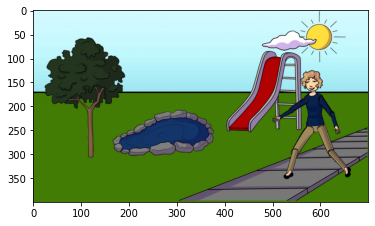

In [168]:
image_item = 2
question_item = 0
out_result(image_item, question_item)

question 1 of the image 29128
 What color is the rug? 

['red', 'red', 'red', 'red', 'brown', 'red', 'red', 'red', 'maroon', 'red']
Top three output ['red', 'red and yellow', 'red and gold'] and probability [0.7122996  0.07557121 0.05348166]


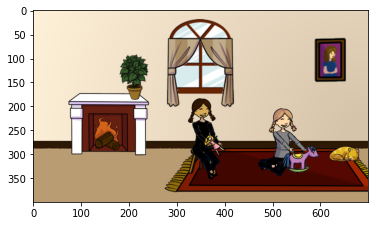

In [169]:
image_item = 0
question_item = 1
out_result(image_item, question_item)

question 2 of the image 29002
 Would the woman be able to watch TV without turning her head? 

['no', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no', 'yes']
Top three output ['yes', 'no', 'maybe'] and probability [9.9970359e-01 2.9606425e-04 3.3283538e-07]


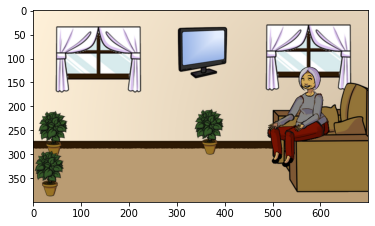

In [170]:
image_item = 20
question_item = 2
out_result(image_item, question_item)

question 1 of the image 28642
 Why is the man running around the dog? 

['exercise', "doesn't look like he's running - calling dog", 'for exercise', 'playing', 'dog is sleeping', 'he is playing', 'exercise', 'exercise', 'bored', 'playing']
Top three output ['playing', 'ball', 'yes'] and probability [0.10724678 0.10212252 0.09138359]


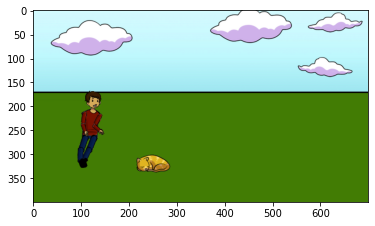

In [171]:
image_item = 40
question_item = 1
out_result(image_item, question_item)

question 2 of the image 28642
 Is the cat sleeping? 

['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
Top three output ['yes', 'no', 'there is no cat'] and probability [9.3350536e-01 6.6457152e-02 1.5028484e-05]


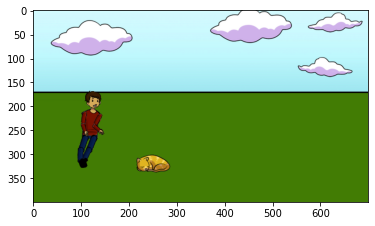

In [172]:
image_item = 40
question_item = 2
out_result(image_item, question_item)

question 1 of the image 21796
 Can you see the entire sun? 

['no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no']
Top three output ['no', 'yes', '0'] and probability [9.7295713e-01 2.7035017e-02 6.7655537e-06]


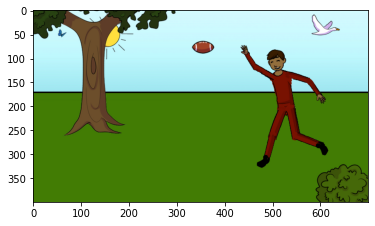

In [174]:
image_item = 60
question_item = 1
out_result(image_item, question_item)

question 2 of the image 20768
 Where is the sun? 

['between trees', 'middle of tree', 'sky', 'between trees', 'between trees', 'in sky', 'about center', 'sky', 'in sky', 'sky']
Top three output ['behind tree', 'sky', 'in sky'] and probability [0.2327321  0.20293249 0.17545858]


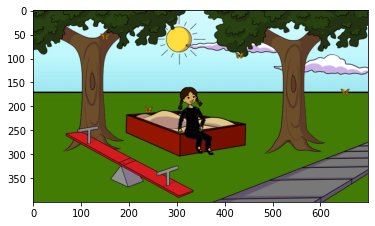

In [176]:
image_item = 100
question_item = 2
out_result(image_item, question_item)

question 2 of the image 26848
 Is there pizza on the table? 

['yes', 'yes', 'yes', 'yes', 'upper left', 'yes', 'yes', 'yes', 'yes', 'yes']
Top three output ['yes', 'no', '2'] and probability [9.6578246e-01 3.4206245e-02 6.3325861e-06]


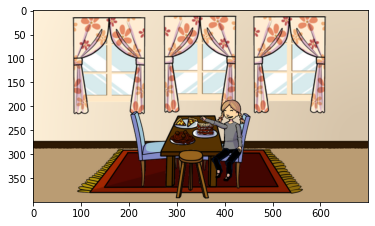

In [178]:
image_item = 200
question_item = 2
out_result(image_item, question_item)

question 1 of the image 26848
 How many windows? 

['3', '3', '3', '3', '3', '3', '3', '3', '3', '3']
Top three output ['2', '3', '5'] and probability [0.34758708 0.3324958  0.1223582 ]


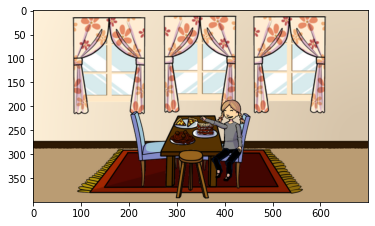

In [180]:
image_item = 200
question_item = 1
out_result(image_item, question_item)